# Model Project

**Table of contents**<a id='toc0_'></a>  
- [1. Objective](#toc1_)
- [2. Import of packages](#toc2_)
- [3. Model description](#toc3_)
- [4. Analytical solution](#toc4_)
- [5. Numerical solution](#toc5_)
- [6. Further analysis](#toc6_)
- [7. Concluding remarks](#toc7_)

## 1. <a id='toc1_'></a>[Objectives](#toc1_)

This notebook examines the OLG model, and look at how population growth affects the outcome of the model.

## 2. <a id='toc2_'></a>[Import of packages](#toc2_)

In [134]:
import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace
import pandas as pd
from ipywidgets import interact
from ipywidgets import interact, FloatSlider

%load_ext autoreload
%autoreload 2

import ipywidgets as widgets

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3. <a id='toc3_'></a>[Model description](#toc3_)

## The OLG Model 

The OLG model consists of 2 periods and 2 groups, young and old. The production function is a standard Cobb-Douglas function:
$$
Y_{t}=AK_{t}^{\alpha}L_{t}^{1-\alpha}
$$
with $t=1,2$ and $1>\alpha>0$. $K$ is capital and $L$ is the labor force which consists entirely of the young population. 
\
\
Capital accumulation is equal to how much is being saved in the economy. Note that it is only the young people who save:
$$
K_{t+1}=s_{t}L_{t}
$$
\
$L_{t}$ is the number of people born in period $t$, which grow at the constant rate, $n$:
$$
L_{t+1}=L_{t}(1+n)
$$


The firms have the profit maximization problem: 
$$
\underset{K_{t}L_{t}}{max}\quad AK_{t}^{\alpha}L_{t}^{1-\alpha}-r_{t}K_{t}-w_{t}L_{t}
$$
with $r_{t}$ and $w_{t}$ being the factor prices. We now that the standard solutions for factor prices in a Cobb-Douglas production function:
$$
r_{t}=A\alpha k_{t}^{\alpha-1}
$$
$$
w_{t}=A(1-\alpha)k_{t}^{\alpha}
$$
with A being the factor productivity, $A>0$. $k_t$ is capital per capita, $k_{t}=\frac{K_{t}}{L_{t}}$


The agents in the economy get utility from consuming:
$$
U_{t}=ln(c_{1t})+\beta ln(c_{2t+1})
$$
with $c_{1t}$ being consumption when young, and $c_{2t+1}$ when old. $\beta=\frac{1}{1+\rho}$, with $\rho$ being the discount rate, $\rho>-1$, ensuring the parameter $\beta$ is positive.

The agents have budget constraints,
$$
c_{1t}+s_{t}=w_{t}
$$
$$
c_{2t+1}=(1+r_{t+1})s_{t}
$$
The young agents consume their wages minus what they save, while the old consume their savings with interests. This yield the lifetime budget constraint, 
$$
c_{1t}+\frac{c_{2t+1}}{1+r_{t+1}}=w_{t}
$$

The basics of the model is now in place. Next step is to solve the household maximization problem:
$$
\underset{c_{1t},c_{2t+1}}{max}\quad ln(c_{1t})+\beta ln(c_{2t+1}) \quad s.t. \quad c_{1t}+\frac{c_{2t+1}}{1+r_{t+1}}=w_{t}
$$
The problem is solved with Lagrange and yields the Euler-equation:
$$
c_{2t+1}=\frac{1+r_{t+1}}{1+\rho}c_{1t}
$$

Combining the Euler-equation with the budget constraints, we obtain the optimal saving:
$$
s_{t}=\frac{1}{2+\rho}w_{t}
$$
Using that $s_{t}=k_{t+1}(1+n)$, we can find the capital accumulation per capita:
$$
k_{t+1}(1+n)=\frac{1}{2+\rho}w_{t}
$$
$$
\Leftrightarrow
$$
$$
k_{t+1}=\frac{A(1-\alpha)k_{t}^{\alpha}}{(1+n)(2+\rho)}
$$

In steady state we have that, $k_{t+1}=k_{t}=k^{*}$:
$$
k^{*}=(\frac{A(1-\alpha)}{(1+n)(2+\rho)})^{\frac{1}{1-\alpha}}
$$

## 4. <a id='toc4_'></a>[Analytical solution](#toc4_)

In this part we will set up the relevant parameters (sm.symbols), solve for steady state(sm.solve), and turn our function into a Python-function (sm.lambdify)

In [36]:
alpha = sm.symbols('alpha')
rho =  sm.symbols('rho')
k = sm.symbols('k')
n = sm.symbols('n')
A = sm.symbols('A')
tau = sm.symbols('tau')

The parameters we use are presented in the table below. 

In [37]:
parameters = {
    'Parameter': ['α', 'ρ', 'n', 'A','tau'],
    'Value': [1/3, 0.05, 0.04, 1, 0]
}
df = pd.DataFrame(parameters)
df['Value'] = df['Value'].round(2)
df

,Parameter,Value
0,α,0.33
1,ρ,0.05
2,n,0.04
3,A,1.00
4,tau,0.00


In [38]:
ss = sm.Eq(k, (A*(1-alpha)*k**alpha)/((1+n)*(2+rho)))
ss

Eq(k, A*k**alpha*(1 - alpha)/((n + 1)*(rho + 2)))

In [39]:
ss_solve = sm.solve(ss, k)[0]
ss_solve

(A*(1 - alpha)/(n*rho + 2*n + rho + 2))**(-1/(alpha - 1))

which is equivalent to the steady state derived in part 3.

In [40]:
k_solve = sm.lambdify((alpha,rho,n,A),ss_solve)
k_solve(1/3,0.05,0.04,1)

0.17485671329443958

With our analytical solution, we get that capital per capita is 0.175 in steady state. 

## 5. <a id='toc5_'></a>[Numerical solution](#toc5_)

Next, we solve numerically. First, we define the values for our set of parameters used in the analysis.





In [41]:
# Defining the values for our set of parameters
rho = 0.05
A = 1.00
alpha = 1/3
n = 0.04
tau = 0.00

# Defining the objective function
obj = lambda k: k - ((A*(1-alpha)*k**alpha)/((1+n)*(2+rho)))

# Optimizing the model and finding the roots
result = optimize.root_scalar(obj,bracket=[1e-10,10],method='bisect') 
k_star = result.root
k_star

0.17485671329430136

Hence, with our numerical analaysis and based on the given parameter values, we also find the steady state to be 0.175.

Since $k_{t+1}$ is a concave function of $k_{t}$ , a unique steady state exists, and convergence to it will occur.

When we subtract the right side from the left side we get the steady state level. This is a function that needs to be optimised and we do this using the root_scalar function as it finds where the function is equal to zero.

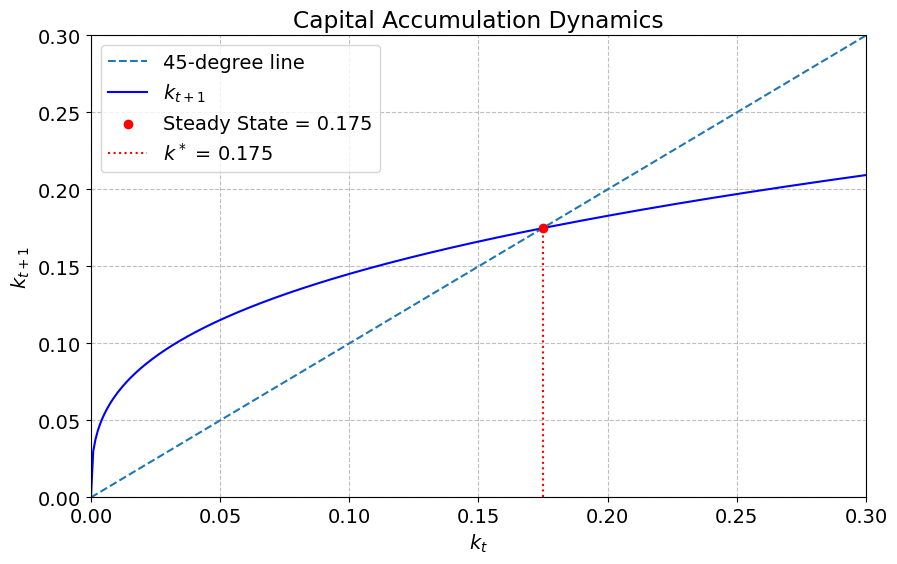

In [99]:
# Defining the values for our set of parameters
rho = 0.05
A = 1.00
alpha = 1/3
n = 0.04
tau = 0.00

# Defining the objective function
obj = lambda k: k - ((A*(1-alpha)*k**alpha)/((1+n)*(2+rho)))

# Optimizing the model and finding the roots
result = optimize.root_scalar(obj, bracket=[1e-10, 10], method='bisect')
k_star = result.root

# Define the range for k_t
k_t = np.linspace(0, 2*k_star, 400)

# Calculate k_t+1 for each k_t
k_t_plus_1 = (A*(1-alpha)*k_t**alpha)/((1+n)*(2+rho))

# Interactive plotting function
def plot_steady_state(steady_state):
    plt.figure(figsize=(10, 6))
    plt.plot(k_t, k_t, label='45-degree line', linestyle='--')
    plt.plot(k_t, k_t_plus_1, label='$k_{t+1}$', color='blue')
    steady_state_y = (A*(1-alpha)*steady_state**alpha)/((1+n)*(2+rho))
    plt.scatter(k_star, [steady_state_y], color='red', zorder=5, label=f'Steady State = {steady_state:.3f}')
    plt.axvline(x=k_star, ymax=0.129/(max(k_t_plus_1)), color='red', linestyle=':', label=f'$k^*$ = 0.175')
    plt.xlabel('$k_t$')
    plt.ylabel('$k_{t+1}$')
    plt.title('Capital Accumulation Growth Path')
    plt.legend()
    plt.grid(True)
    plt.ylim([0, 0.3]) 
    plt.xlim([0, 0.3])  
    plt.show()

# Display the interactive plot with the initial steady state value
plot_steady_state(k_star)

## 6. <a id='toc6_'></a>[Further analysis](#toc6_)


#### Effect of implementing a Pay As You Go system

In this section, we will use a different approach to solve the model compared to the previous section. Here, we will examine the PAYG-system which we will briefly account for:


In the PAYG-system, the government collects contributions $d_t$ from current young, and pays them out as benefits to current old:
$$
b_t=(1+n)d_t
$$
We assume the the contributions are a fixed fraction of wage ($d_t=\tau w_t$). This yields the budget constraints:
$$
c_{1t}+s_t+d_t=w_t
$$
for young. For old: 
$$
c_{2t+1}=(1+r_{t+1})s_t+(1+n)d_{t+1}
$$
Euler equation is unchanged since the contributions are taken for given. Savings are: 
$$
s_t=(1+n)k_{t+1}
$$


One can derive the closed form expression for individual savings:
$$
s_t=\frac{1}{2+\rho}[(w_t-d_t)-\frac{1+\rho}{r_{t+1}}(1+n)d_{t+1}]
$$
Likewise one can show the equilibrium expression for $k_{t+1}$:
$$
k_{t+1}=\frac{1}{1+\frac{1+\rho}{2+\rho}\frac{(1-\alpha)}{\alpha}\tau}(\frac{1}{(1+n)(2+\rho)}(1-\tau)w_t)
$$

Below we will examine the implementation of the PAYG system and show the transition path.

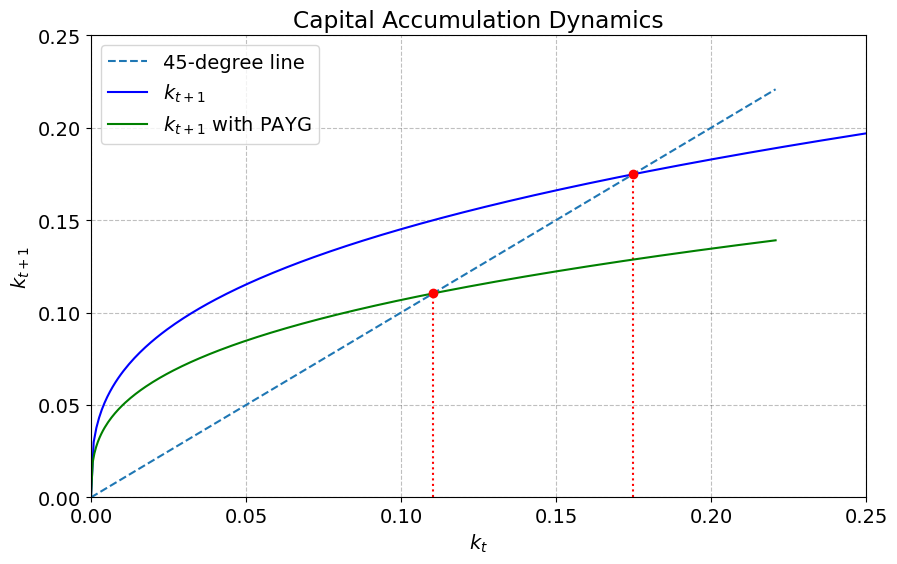

In [137]:
# Defining the values for our set of parameters
tau = 0.35

obj_payg = lambda k: k - ((A * (1 - alpha) * k**alpha) / ((1 + n) * (2 + rho)) * (1 / (1 + ((1 + rho) / (2 + rho)) * ((1 - alpha) / alpha) * tau)))

result_payg = optimize.root_scalar(obj_payg, bracket=[1e-10,10], method='bisect')
k_star_payg = result_payg.root

k_t_payg = np.linspace(0, 2*k_star_payg, 400)
k_t_plus_1_payg = ((A * (1 - alpha) * k_t_payg**alpha) / ((1 + n) * (2 + rho)) * (1 / (1 + ((1 + rho) / (2 + rho)) * ((1 - alpha) / alpha) * tau)))

def plot_steady_state_payg(steady_state_payg):
    plt.figure(figsize=(10, 6))
    plt.plot(k_t_payg, k_t_payg, label='45-degree line', linestyle='--')

    plt.plot(k_t, k_t_plus_1, label='$k_{t+1}$', color='blue')
    plt.scatter(0.175, 0.175, color='red', zorder=5)
    plt.axvline(x=k_star, ymax=0.155/(max(k_t_plus_1)), color='red', linestyle=':')

    plt.plot(k_t_payg, k_t_plus_1_payg, label='$k_{t+1}$ with PAYG', color='green')
    plt.axvline(x=k_star_payg, ymax=0.1/(max(k_t_plus_1)), color='red', linestyle=':')

    plt.scatter([steady_state_payg], [steady_state_payg], color='red', zorder=5)
    plt.xlabel('$k_t$')
    plt.ylabel('$k_{t+1}$')
    plt.title('Capital Accumulation Growth Path')
    plt.ylim(0, 0.25)
    plt.xlim(0, 0.25) 
    plt.legend(loc='upper left')
    plt.show()

# Display the interactive plot with the initial steady state value
plot_steady_state_payg(k_star_payg)

In this example we assumed the distribution to be 35% of wages. However, this distribution can vary at all levels between 0 and 1. In the interactive figure below we allow the tax to flow between 0 and 1, the result being that a higher distribution (tax) means lower level of capital in steady state. 

In [141]:
# Define the range of k_t
k_t = np.linspace(0, 0.25, 400)

# Define the function to calculate steady state capital with PAYG tax
def calculate_steady_state_payg(tau):
    obj_payg = lambda k: k - ((A * (1 - alpha) * k**alpha) / ((1 + n) * (2 + rho)) * (1 / (1 + ((1 + rho) / (2 + rho)) * ((1 - alpha) / alpha) * tau)))
    result_payg = optimize.root_scalar(obj_payg, bracket=[1e-10, 10], method='bisect')
    k_star_payg = result_payg.root
    
    k_t_plus_1 = ((A * (1 - alpha) * k_t**alpha) / ((1 + n) * (2 + rho)))
    k_t_plus_1_payg = ((A * (1 - alpha) * k_t**alpha) / ((1 + n) * (2 + rho)) * (1 / (1 + ((1 + rho) / (2 + rho)) * ((1 - alpha) / alpha) * tau)))
    
    return k_t_plus_1, k_t_plus_1_payg, k_star_payg

# Interactive plotting function
def plot_steady_state_payg(tau):
    k_t_plus_1, k_t_plus_1_payg, k_star_payg = calculate_steady_state_payg(tau)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_t, k_t, label='45-degree line', linestyle='--')
    plt.plot(k_t, k_t_plus_1, label='$k_{t+1}$', color='blue')
    plt.plot(k_t, k_t_plus_1_payg, label='$k_{t+1}$ with PAYG', color='green')
    plt.scatter(k_star_payg, k_star_payg, color='red', zorder=5, label=f'Steady State with PAYG = {k_star_payg:.3f}')
    plt.xlabel('$k_t$')
    plt.ylabel('$k_{t+1}$')
    plt.title('Capital Accumulation Growth Path')
    plt.ylim(0, 0.25)
    plt.xlim(0, 0.25)
    plt.legend()
    plt.grid(True)
    plt.show()

# Create an interactive widget with FloatSlider for tau
interact(plot_steady_state_payg, tau=FloatSlider(min=0.0, max=1, step=0.1, value=0.35))

interactive(children=(FloatSlider(value=0.35, description='tau', max=1.0), Output()), _dom_classes=('widget-in…

<function __main__.plot_steady_state_payg(tau)>

In [148]:
# Define the function to calculate steady state capital with PAYG tax
def calculate_steady_state_payg(tau, n):
    obj_payg = lambda k: k - ((A * (1 - alpha) * k**alpha) / ((1 + n) * (2 + rho)) * (1 / (1 + ((1 + rho) / (2 + rho)) * ((1 - alpha) / alpha) * tau)))
    result_payg = optimize.root_scalar(obj_payg, bracket=[1e-10, 10], method='bisect')
    k_star_payg = result_payg.root
    
    k_t_plus_1 = ((A * (1 - alpha) * k_t**alpha) / ((1 + n) * (2 + rho)))
    k_t_plus_1_payg = ((A * (1 - alpha) * k_t**alpha) / ((1 + n) * (2 + rho)) * (1 / (1 + ((1 + rho) / (2 + rho)) * ((1 - alpha) / alpha) * tau)))
    
    return k_t_plus_1, k_t_plus_1_payg, k_star_payg

# Interactive plotting function
def plot_steady_state_payg(tau, n):
    k_t_plus_1, k_t_plus_1_payg, k_star_payg = calculate_steady_state_payg(tau, n)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_t, k_t, label='45-degree line', linestyle='--')
    plt.plot(k_t, k_t_plus_1, label='$k_{t+1}$', color='blue')
    plt.plot(k_t, k_t_plus_1_payg, label='$k_{t+1}$ with PAYG', color='green')
    plt.scatter(k_star_payg, k_star_payg, color='red', zorder=5, label=f'Steady State with PAYG = {k_star_payg:.3f}')
    plt.xlabel('$k_t$')
    plt.ylabel('$k_{t+1}$')
    plt.title('Capital Accumulation Dynamics')
    plt.ylim(0, 0.25)
    plt.xlim(0, 0.25)
    plt.legend()
    plt.grid(True)
    plt.show()

# Create an interactive widget with FloatSliders for tau and n
interact(plot_steady_state_payg, tau=FloatSlider(min=0, max=1, step=0.1, value=0.35), n=FloatSlider(min=-0.1, max=0.1, step=0.01, value=0.04))

interactive(children=(FloatSlider(value=0.35, description='tau', max=1.0), FloatSlider(value=0.04, description…

<function __main__.plot_steady_state_payg(tau, n)>

We see that the implementation of the PAYG-system makes the steady state capital level fall. From the equilibrium capital accumulation equation previously written up for period $t+1$ we see an inverse relationship between the level of tax, $\tau$, and capital accumulation, $k_{t+1}$, such that an increase in $\tau$ leads to a decrease in $k_{t+1}$. 

As it is only the the working-age generation that pay taxes in the OLS model, the tax will exclusively fall on the young generation (to finance government spendning). As a result, the present discounted value (PDV) of lifetime disposable income decreases for the young. 

Hence, the young generation seek to smooth their consumption over their lifetimes. And with a lower PDV of disposable lifetime income, the young generation adjusts by reducing their overall consumption. Given the structure of the Euler equation preseted earlier, to smooth consumption, the young must both reduce their consumption in period $t$ (when young) and in period $t+1$ (when old) - such that they save less today, which leads to a decrease in current savings. 

In the OLG model, savings directly translates to capital accumulation. So when individuals decrease savings, capital accumulation falls as dislayed by the figure above. 



## 7. <a id='toc7_'></a>[Concluding remarks](#toc7_)

In sum, the first figure shows the analytical steady state of approximately 0.175 in the absence of shocks. However, when subjected to an unexpected increase in government spending, achieved through lump-sum taxes levied per worker on the young each period, the capital accumulation decreases accordingly.